## 4. Deep Lerning

### 4.1 Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


### 4.2 Load up Baarle Hertog data

In [2]:
m = cv2.imread('data/Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:, :, (2, 1, 0)]

belgium_color = np.array([251, 234, 81])
netherlands_color = np.array([255, 255, 228])

netherlands_region = ((m - netherlands_color)**2).sum(-1) < 50
belgium_region = ((m - belgium_color)**2).sum(-1) < 10000

b_coords = np.array(np.where(belgium_region)).T.astype('float')
n_coords = np.array(np.where(netherlands_region)).T.astype('float')

# Flip and normalize coordinates to [-1, 1]
belgium_coords_all = np.zeros_like(b_coords)
netherlands_coords_all = np.zeros_like(n_coords)

belgium_coords_all[:, 0] = b_coords[:, 1] / (960 / 2) - 1
belgium_coords_all[:, 1] = (960 - b_coords[:, 0]) / (960 / 2) - 1
netherlands_coords_all[:, 0] = n_coords[:, 1] / (960 / 2) - 1
netherlands_coords_all[:, 1] = (960 - n_coords[:, 0]) / (960 / 2) - 1

In [3]:
np.random.seed(55)
num_points_to_sample = 10000
belgium_coords_sample = belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords_sample = netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]
X_sample = np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample = np.concatenate((np.zeros(len(belgium_coords_sample)), np.ones(len(netherlands_coords_sample)))).astype('int')

rI=np.arange(len(y_sample))
np.random.shuffle(rI)
X_sample=X_sample[rI,:]
y_sample=y_sample[rI]

X_sample = torch.FloatTensor(X_sample)
y_sample = torch.tensor(y_sample)

In [4]:
# Full dataset (no sampling)
belgium_coords = belgium_coords_all
netherlands_coords = netherlands_coords_all

X = np.vstack((netherlands_coords, belgium_coords))
y = np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [5]:
X_tensor.shape, y_tensor.shape, X_sample.shape, y_sample.shape

(torch.Size([855665, 2]),
 torch.Size([855665]),
 torch.Size([20000, 2]),
 torch.Size([20000]))

In [6]:
y_sample[:100]

tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1])

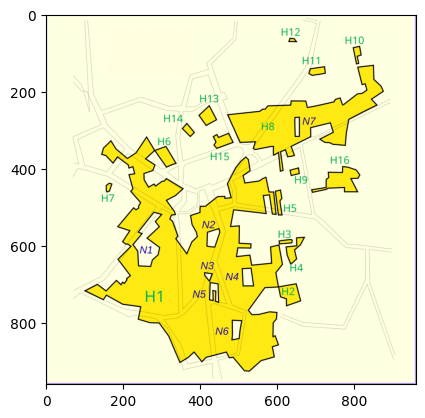

In [7]:
plt.imshow(m)

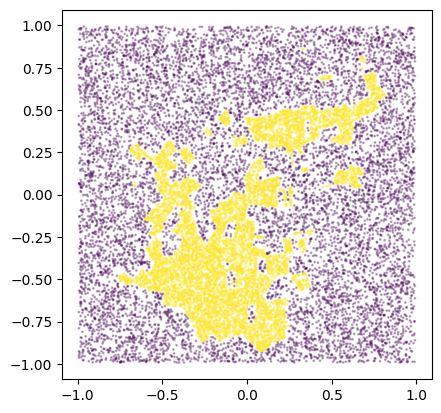

In [8]:
plt.scatter(X_sample[:,0], X_sample[:,1], c=y_sample, s=1, alpha=0.3); plt.axis('square');

### 4.3 Network 

In [9]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers = layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [10]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig = plt.figure(0, (6, 6))
    ax = fig.add_subplot(111)

    probe = np.zeros((res, res, 2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k] = [yy, xx]
    probe = probe.reshape(res**2, -1)
    probe_logits = model(torch.tensor(probe).float().to(device))
    probe_logits = probe_logits.detach().cpu().numpy().reshape(res, res, 2)

    ax.imshow(m.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits, 2)),
               extent=[0, 960, 960, 0],
               alpha=0.7,
               cmap='viridis')

### 4.4 Two Layers, Three Hidden Neurons (Figure 4.1)

In [11]:
random_seed=520 #Random seed of 3 makes for a nice "fold down the edges" deal, wait that's for 2x2
num_neurons=3

torch.manual_seed(random_seed)  

# Initialize model and optimizer
model = BaarleNet([num_neurons])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.01) #0.005

num_epochs = 10000
for epoch in range(num_epochs):

    #Stochastic - works better for these smaller netowkrs. 
    outputs = model(torch.tensor(X_sample[epoch%len(y_sample)]).float())
    loss = criterion(outputs, torch.tensor(y_sample[epoch%len(y_sample)])) 
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_sample)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_sample).sum().item()/len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

/tmp/ipykernel_31445/865202863.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(X_sample[epoch%len(y_sample)]).float())
/tmp/ipykernel_31445/865202863.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(y_sample[epoch%len(y_sample)]))


Epoch [400/10000], Loss: 0.3467, Accuracy: 0.6342
Epoch [800/10000], Loss: 0.6061, Accuracy: 0.6925
Epoch [1200/10000], Loss: 0.5865, Accuracy: 0.7683
Epoch [1600/10000], Loss: 0.4375, Accuracy: 0.8077
Epoch [2000/10000], Loss: 1.0100, Accuracy: 0.7941
Epoch [2400/10000], Loss: 0.3538, Accuracy: 0.7858
Epoch [2800/10000], Loss: 0.8983, Accuracy: 0.8068
Epoch [3200/10000], Loss: 0.2023, Accuracy: 0.8050
Epoch [3600/10000], Loss: 0.3616, Accuracy: 0.8170
Epoch [4000/10000], Loss: 0.1266, Accuracy: 0.8321
Epoch [4400/10000], Loss: 0.1828, Accuracy: 0.8265
Epoch [4800/10000], Loss: 3.1891, Accuracy: 0.7879
Epoch [5200/10000], Loss: 0.1795, Accuracy: 0.8265
Epoch [5600/10000], Loss: 0.1350, Accuracy: 0.8016
Epoch [6000/10000], Loss: 0.4167, Accuracy: 0.8083
Epoch [6400/10000], Loss: 0.0441, Accuracy: 0.8385
Epoch [6800/10000], Loss: 0.3843, Accuracy: 0.8183
Epoch [7200/10000], Loss: 0.1611, Accuracy: 0.8291
Epoch [7600/10000], Loss: 0.1842, Accuracy: 0.8472
Epoch [8000/10000], Loss: 0.2445,

<Figure size 640x480 with 0 Axes>

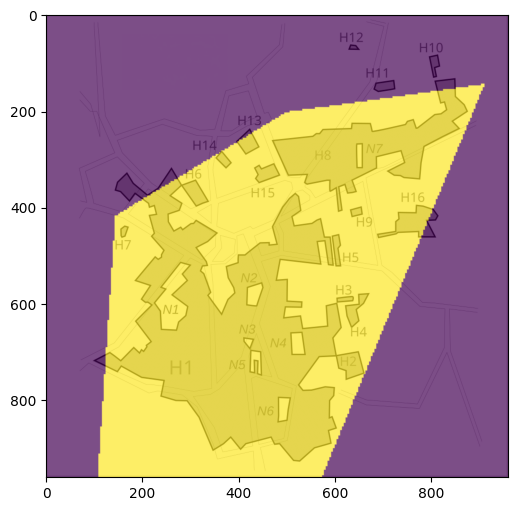

In [12]:
viz_descision_boundary(model.to(device))

### 4.4 Two Layers, Eight Hidden Neurons (Figure 4.4)

In [14]:
batch_size = 10000
random_seed = 26

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([8]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 3

Epoch [1/3], Loss: 0.3078, Accuracy: 0.7886
Epoch [2/3], Loss: 0.2484, Accuracy: 0.8220
Epoch [3/3], Loss: 0.2135, Accuracy: 0.8445


<Figure size 640x480 with 0 Axes>

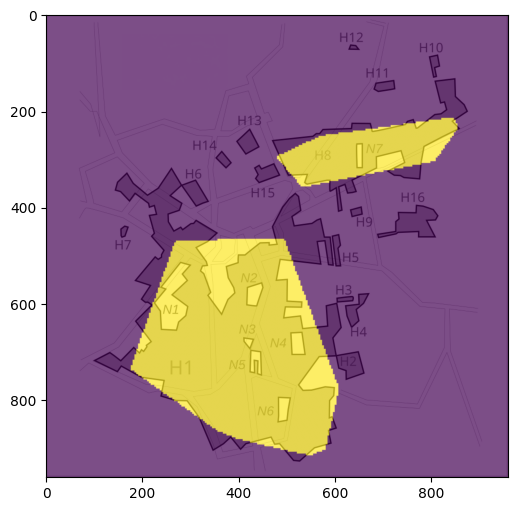

In [15]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Calculate accuracy on sample dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)

### 4.5 Wider Models (Figure 4.5)
Ramp up width as desired here

In [18]:
batch_size = 10000
random_seed = 26

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = BaarleNet([16]).to(device) #Ramp up model width here as desired
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
num_epochs = 5

Epoch [1/5], Loss: 0.3277, Accuracy: 0.7601
Epoch [2/5], Loss: 0.2503, Accuracy: 0.7901
Epoch [3/5], Loss: 0.2205, Accuracy: 0.8505
Epoch [4/5], Loss: 0.2063, Accuracy: 0.8500
Epoch [5/5], Loss: 0.2038, Accuracy: 0.8577


<Figure size 640x480 with 0 Axes>

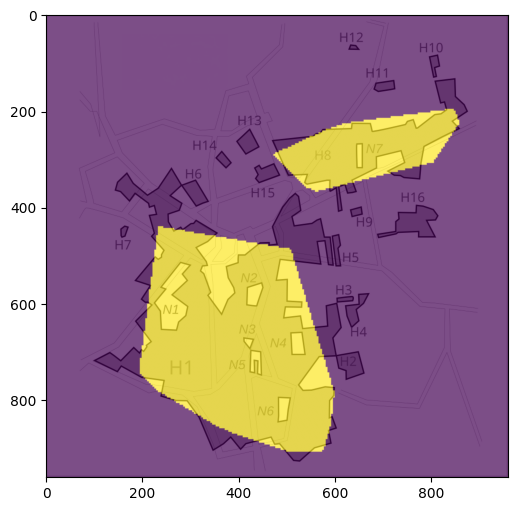

In [17]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Calculate accuracy on sample dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)

### 4.6 Network Walkthrough -  Figure 4.14
Repoduce network walkthrough in Figure 4.14 

In [19]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

In [20]:
map = cv2.imread('data/Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color = np.array([251, 234, 81])
netherlands_color = np.array([255, 255, 228])

netherlands_region = ((map - netherlands_color)**2).sum(-1) < 10
belgium_region = ((map - belgium_color)**2).sum(-1) < 10000

num_points_to_sample = 10000

b_coords = np.array(np.where(belgium_region)).T.astype('float')
n_coords = np.array(np.where(netherlands_region)).T.astype('float')

# Flip and normalize
belgium_coords_all = np.zeros_like(b_coords)
netherlands_coords_all = np.zeros_like(n_coords)

belgium_coords_all[:,0] = b_coords[:,1]/(960/2) - 1
belgium_coords_all[:,1] = (960 - b_coords[:,0])/(960/2) - 1
netherlands_coords_all[:,0] = n_coords[:,1]/(960/2) - 1
netherlands_coords_all[:,1] = (960 - n_coords[:,0])/(960/2) - 1

belgium_coords = belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords = netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X = np.vstack((netherlands_coords, belgium_coords))
y = np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI = np.arange(len(y))
np.random.shuffle(rI)
X = X[rI,:]
y = y[rI]

In [21]:
class BaarleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 2)
        )
    
    def forward(self, x):
        return self.model(x)

In [22]:
model = BaarleNet()
model.load_state_dict(torch.load('data/2_1.pth'))
model.eval()

/tmp/ipykernel_31445/3093492321.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/2_1.pth'))


BaarleNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [23]:
print("First layer (input → hidden):")
print("W1 =", model.model[0].weight.data.numpy())
print("b1 =", model.model[0].bias.data.numpy())
print("\nSecond layer (hidden → output):")
print("W2 =", model.model[2].weight.data.numpy())
print("b2 =", model.model[2].bias.data.numpy())

First layer (input → hidden):
W1 = [[ 2.513498  -1.024808 ]
 [-1.404299   2.4129117]]
b1 = [-1.2398118  -0.45007765]

Second layer (hidden → output):
W2 = [[ 3.170242   1.3256735]
 [-3.4037237 -1.5387845]]
b2 = [-0.8848354   0.03322279]


In [24]:
x_test = np.array([0.6, 0.4])
x_belgium = torch.tensor(x_test, dtype=torch.float32)
print("Input:", x_test)

Input: [0.6 0.4]


In [25]:
with torch.no_grad():
    # First layer (before ReLU)
    h1_pre = model.model[0](x_belgium)
    print("After first linear layer (before ReLU):", h1_pre.numpy())
    
    # After ReLU
    h1_post = model.model[:2](x_belgium)
    print("After ReLU activation:", h1_post.numpy())
    
    # Output layer
    output = model(x_belgium)
    print("Final output (Netherlands, Belgium):", output.numpy())

After first linear layer (before ReLU): [-0.14163601 -0.32749242]
After ReLU activation: [0. 0.]
Final output (Netherlands, Belgium): [-0.8848354   0.03322279]


In [26]:
# Extract weights
W1 = model.model[0].weight.data.numpy()
b1 = model.model[0].bias.data.numpy()
W2 = model.model[2].weight.data.numpy()
b2 = model.model[2].bias.data.numpy()

x = x_test

# First layer computation
h1_pre = W1 @ x + b1
print("First layer (before ReLU):", h1_pre)

# ReLU activation
h1_post = np.maximum(0, h1_pre)
print("After ReLU:", h1_post)

# Second layer computation
output = W2 @ h1_post + b2
print("Final output:", output)
print("Predicted class:", "Belgium" if output[1] > output[0] else "Netherlands")

First layer (before ReLU): [-0.14163616 -0.3274924 ]
After ReLU: [0. 0.]
Final output: [-0.88483542  0.03322279]
Predicted class: Belgium


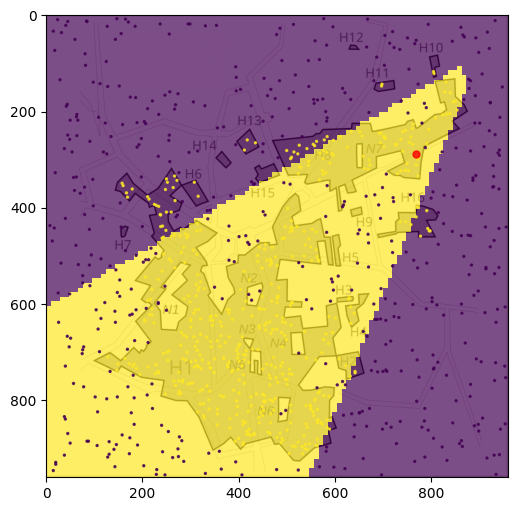

In [27]:
fig = plt.figure(0, (6, 6))
ax = fig.add_subplot(111)

ax.imshow(map.mean(2), cmap='gray')

X_denorm = denorm(X[:1000,:])
plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)

X_denorm = denorm(x_test)
plt.scatter(X_denorm[0], X_denorm[1], c='r', s=25, alpha=0.8)

probe = np.zeros((100, 100, 2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k] = [yy, xx]
probe = probe.reshape(100**2, -1)
probe_logits = model(torch.tensor(probe).float())
probe_logits = probe_logits.detach().numpy().reshape(100, 100, 2)
ax.imshow(np.flipud(np.argmax(probe_logits, 2)), 
           extent=[0, 960, 960, 0],
           alpha=0.7,
           cmap='viridis')